In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import glob
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Meiryo'

In [2]:
g = glob.glob('./dataset/*.csv')
fn = g[0]

out_dir = './dataset_o/'
os.makedirs(out_dir, exist_ok=True) 
baseimage_fn = './baseimage.jpg'

In [3]:
df = pd.read_csv(fn,index_col = 0)
dfx = df.loc[df['INFO'] == 'OK']

out_fn = fn.replace('./dataset',out_dir)
dfx.to_csv(out_fn)

In [44]:
def IsFlip(data:np.ndarray,fn):
    gray = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=0.99, minDist=100, param1=128, param2=60, minRadius=60, maxRadius=0)

    ##circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=0.9, minDist=90, param1=128, param2=60, minRadius=60, maxRadius=0)
    if( type(circles) is np.ndarray) == False:
        print('error:', fn )
        return None
       
    assert(len(circles) > 0)
    dest = data.shape[0]//2 > circles[0][0][1]
    return dest
    

## 赤石検出
def RedStoneDetect(data:np.ndarray):
    new_img = cv2.cvtColor(data, cv2.COLOR_RGBA2BGR)
    color = np.array([0,0,255])
    new_img = cv2.inRange(new_img , color,color)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opening = cv2.morphologyEx(new_img, cv2.MORPH_OPEN, kernel )
    contours, hierarchy = cv2.findContours(opening,mode=cv2.RETR_CCOMP,method =cv2.CHAIN_APPROX_TC89_L1)

    ##print(len(contours) == 8 )
    red_contours = []
    for i in range(len(contours)):
         ## -- トップレベル & 子を持たない
        if (hierarchy[0][i][3] == -1) & (hierarchy[0][i][2] == -1):
            red_contours.append(contours[i])

    return red_contours
    pass
## 黄石検出
def YellowStoneDetect(data:np.ndarray):
    new_img = cv2.cvtColor(data, cv2.COLOR_RGBA2BGR)
    color = np.array([0,255,255])
    new_img = cv2.inRange(new_img , color,color)
    contours, hierarchy = cv2.findContours(new_img,mode=cv2.RETR_CCOMP,method =cv2.CHAIN_APPROX_TC89_L1)

    def yellowFilter( contours, hierarchy ):
        ignore_indexList = []
        for i in range(len(contours)):
            if (hierarchy[0][i][3] != -1) : ## 親を持つ　かつ面積20以上
                if  cv2.contourArea(contours[i]) > 10: ## 面積10以上
                    ignore_indexList.append(hierarchy[0][i][3])
        return ignore_indexList
    
    ignore  = yellowFilter( contours, hierarchy )

    yellow_contours = []
    for i in range(len(contours)):
         ## トップ
        if (hierarchy[0][i][3] == -1) & (i not in ignore):
            yellow_contours.append(contours[i])
    
    return yellow_contours
    pass

In [45]:
def ShowImage(img):
    fig, ax = plt.subplots(figsize=(3,4))
    ax.imshow(img)
    ax.axis('off')

In [46]:
def img_funv(fn,img_dir):
    pImage = Image.open(fn)
    ##------------------------
    data = np.array(pImage)
    #ShowImage(data)
    #print(fn,data.shape)
    dest = IsFlip(data, fn)
    if dest == None:
        return
        
    ##print(fn,dest)
    numpy_image = data.copy()
    if dest == True:
        numpy_image = cv2.flip(numpy_image, -1)
    y_cvontours = YellowStoneDetect(numpy_image)
    r_cvontours = RedStoneDetect(numpy_image)
    ##------------------------
    outImage = Image.open(baseimage_fn)
    outdata = np.array(outImage)
    dest_img = cv2.cvtColor(outdata, cv2.COLOR_RGBA2BGR)
    cv2.drawContours(dest_img, r_cvontours, -1,  (0, 0, 255), -1)
    cv2.drawContours(dest_img, y_cvontours, -1,  (0, 255, 255), -1)
    dest_img = cv2.cvtColor(dest_img, cv2.COLOR_BGR2RGB)
    dest_img = dest_img[20:560,:,:] ## clip
    ##------------------------
    pil_image = Image.fromarray(dest_img.astype(np.uint8))
    bfn = os.path.basename(fn)
    out_path = os.path.join( img_dir , bfn)
    pil_image.save(out_path)

In [48]:
for fn in g:
    print('START',fn)
    df = pd.read_csv(fn,index_col = 0)
    dfx = df.loc[df['INFO'] == 'OK']
    
    dir = os.path.basename(fn).split('.')[0]
    img_dir = os.path.join( out_dir,dir)
    os.makedirs(img_dir, exist_ok=True) 
    print(img_dir)
    pathlist = dfx['filepath'].map(lambda fn:os.path.join( './dataset/',dir,fn))
    for fnx in pathlist:
        img_funv(fnx,img_dir)
    
    out_fn = fn.replace('./dataset',out_dir)
    dfx.to_csv(out_fn)
    print(out_fn)

START ./dataset\CWC2018-19_Leg1_ResultsBook.csv
./dataset_o/CWC2018-19_Leg1_ResultsBook
./dataset_o/\CWC2018-19_Leg1_ResultsBook.csv
START ./dataset\CWC2018-19_Leg2_ResultsBook.csv
./dataset_o/CWC2018-19_Leg2_ResultsBook
./dataset_o/\CWC2018-19_Leg2_ResultsBook.csv
START ./dataset\CWC2018-19_Leg3_ResultsBook.csv
./dataset_o/CWC2018-19_Leg3_ResultsBook
./dataset_o/\CWC2018-19_Leg3_ResultsBook.csv
START ./dataset\ECC2017_ResultsBook_Men_A-Division.csv
./dataset_o/ECC2017_ResultsBook_Men_A-Division
./dataset_o/\ECC2017_ResultsBook_Men_A-Division.csv
START ./dataset\ECC2017_ResultsBook_Women_A-Division.csv
./dataset_o/ECC2017_ResultsBook_Women_A-Division
./dataset_o/\ECC2017_ResultsBook_Women_A-Division.csv
START ./dataset\ECC2018_ResultsBook_Men_A-Division.csv
./dataset_o/ECC2018_ResultsBook_Men_A-Division
./dataset_o/\ECC2018_ResultsBook_Men_A-Division.csv
START ./dataset\ECC2018_ResultsBook_Women_A-Division.csv
./dataset_o/ECC2018_ResultsBook_Women_A-Division
./dataset_o/\ECC2018_Result

In [49]:
q = [
'./dataset/OWG2018_ResultsBook\geme93end2.png',
'./dataset/OWG2018_ResultsBook\geme346end2.png',
'./dataset/OWG2018_ResultsBook\geme357end10.png',
'./dataset/OWG2018_ResultsBook\geme622end4.png',
'./dataset/OWG2018_ResultsBook\geme823end10.png',
'./dataset/OWG2018_ResultsBook\geme858end10.png',
'./dataset/OWG2018_ResultsBook\geme1159end8.png',
'./dataset/PACC2018_ResultsBook_Men\geme5end10.png',
'./dataset/PACC2018_ResultsBook_Men\geme165end6.png',
'./dataset/PACC2018_ResultsBook_Men\geme327end6.png',
'./dataset/PACC2018_ResultsBook_Women\geme94end2.png',
'./dataset/PACC2018_ResultsBook_Women\geme125end6.png',
'./dataset/PACC2018_ResultsBook_Women\geme172end8.png']

In [51]:
fn = q[-1]

(600, 300, 3)


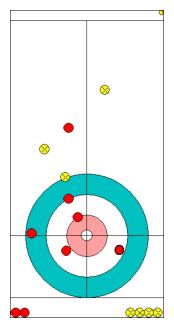

In [52]:
pImage = Image.open(fn)
print(np.array(pImage).shape)
ShowImage(pImage)

In [94]:
def IsFlip2(data:np.ndarray,fn):
    gray = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=0.99, minDist=100, param1=128, param2=40, minRadius=60, maxRadius=0)

    ##circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=0.9, minDist=90, param1=128, param2=60, minRadius=60, maxRadius=0)
    if( type(circles) is np.ndarray) == False:
        print('error:', fn )
        return None
       
    assert(len(circles) > 0)
    dest = data.shape[0]//2 > circles[0][0][1]
    return dest

In [95]:
def img_funv2(fn,img_dir):
    pImage = Image.open(fn)
    ##------------------------
    data = np.array(pImage)
    #ShowImage(data)
    #print(fn,data.shape)
    dest = IsFlip2(data, fn)
    print(fn,dest)


In [96]:
for fn in q:
    img_funv2(fn,'x')

./dataset/OWG2018_ResultsBook\geme93end2.png False
./dataset/OWG2018_ResultsBook\geme346end2.png False
./dataset/OWG2018_ResultsBook\geme357end10.png False
./dataset/OWG2018_ResultsBook\geme622end4.png False
./dataset/OWG2018_ResultsBook\geme823end10.png False
./dataset/OWG2018_ResultsBook\geme858end10.png False
./dataset/OWG2018_ResultsBook\geme1159end8.png False
./dataset/PACC2018_ResultsBook_Men\geme5end10.png False
./dataset/PACC2018_ResultsBook_Men\geme165end6.png False
./dataset/PACC2018_ResultsBook_Men\geme327end6.png False
./dataset/PACC2018_ResultsBook_Women\geme94end2.png False
./dataset/PACC2018_ResultsBook_Women\geme125end6.png False
./dataset/PACC2018_ResultsBook_Women\geme172end8.png False


In [ ]:
## 変換エラー